# Run experiments on GSFuzzyCMeans

## 1. Experiments!

In [ ]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn.metrics import adjusted_rand_score, davies_bouldin_score, silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from tqdm import tqdm
from itertools import product
import time
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
from preprocessing import DataLoader, DataProcessor
# from fuzzy import GSFuzzyCMeans
from kmeans import kmeans

# Define evaluation metrics
metrics = {
    "Adjusted Rand Index": adjusted_rand_score,
    "Davies-Bouldin Index": davies_bouldin_score,
    "Silhouette Score": silhouette_score
}

def purity_score(y_true, y_pred):
    # Compute the contingency matrix
    matrix = contingency_matrix(y_true, y_pred)
    # Calculate purity
    return np.sum(np.amax(matrix, axis=0)) / np.sum(matrix)

# fuzzy_exponents = [1.5, 2.5, 3.5]
# xi_values       = [0.3, 0.5, 0.7]
k_values        = range(2, 16)
distance_metrics = ['euclidean', 'manhattan', 'cosine']
seeds = [0, 42, 36, 12, 55, 100, 67, 24, 79, 33]

# Prepare parameter combinations
parameter_combinations = list(product(k_values, distance_metrics, seeds))
print(f"Total parameter combinations: {len(parameter_combinations)}")

# Create results directory
os.makedirs("results", exist_ok=True)

def run_experiment(args):
    dataset_name, parameters = args
    k, dist, seed = parameters
    num_runs = len(seeds)  # Number of runs per configuration
    # num_runs = 1

    try:
        # Initialize loaders and preprocessors
        data_loader = DataLoader()
        data_processor = DataProcessor()

        # Load dataset
        data, labels = data_loader.load_arff_data(dataset_name)
        X = data_processor.preprocess_dataset(data)
        y_true = labels

        # Accumulate scores over multiple runs
        scores = {
            "k": k, "distance": dist, "seed": seed,
            "Adjusted Rand Index"   : 0.0,
            "Davies-Bouldin Index"  : 0.0,
            "Silhouette Score"      : 0.0,
            "Purity Score"          : 0.0,
            "Time (s)"              : 0.0,
            "Iterations"            : 0
        }

        for idx in range(num_runs):
            start_time = time.time()
            # gs_fcm = GSFuzzyCMeans(n_clusters=k, m=m, xi=xi, max_iter=100, random_state=None)
            # gs_fcm.fit(X)
            # y_pred = gs_fcm.predict(X)
            km = kmeans.KMeans(k=k, distance=dist, seed=seeds[idx])
            y_pred = km.fit_predict(X)
            # print(len(y_pred))
            elapsed_time = time.time() - start_time

            # Update scores
            scores["Adjusted Rand Index"]   += adjusted_rand_score(y_true, y_pred)
            scores["Davies-Bouldin Index"]  += davies_bouldin_score(X, y_pred)
            scores["Silhouette Score"]      += silhouette_score(X, y_pred)
            scores["Purity Score"]          += purity_score(y_true, y_pred)
            scores["Time (s)"]              += elapsed_time
            scores["Iterations"]            += km.n_iter_
            # scores["Iterations"]            += km.n_iter_

        # Average scores
        for key in ["Adjusted Rand Index", "Davies-Bouldin Index", "Silhouette Score", "Purity Score", "Time (s)", "Iterations"]:
            scores[key] /= num_runs

        return scores

    except Exception as e:
        # Return the exception with parameters for easier debugging
        return {"k": k, "distance": dist, "Error": str(e)}

datasets = ["vowel", "splice", "satimage"]


Total parameter combinations: 420


In [3]:
for dataset_name in datasets:
    print(f"\nRunning experiments for {dataset_name} dataset...")
    results_file = f"results/KMEANS_seed_{dataset_name}_results_AVG.csv"

    # Check if the results file exists to determine if we need to write headers
    file_exists = os.path.isfile(results_file)

    # Prepare experiments
    experiments = [(dataset_name, params) for params in parameter_combinations]

    # Run experiments in parallel
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(run_experiment, args): args for args in experiments}

        # Open the CSV file in append mode
        with open(results_file, 'a', newline='') as csvfile:
            fieldnames = ["k", "distance", "seed", "Adjusted Rand Index", "Davies-Bouldin Index",
                        "Silhouette Score", "Purity Score", "Time (s)", "Iterations", "Error"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            # Write header only if the file doesn't exist or is empty
            if not file_exists or os.stat(results_file).st_size == 0:
                writer.writeheader()

            for future in tqdm(as_completed(futures), total=len(experiments), desc=f"Processing {dataset_name}"):
                try:
                    result = future.result()
                    # Write the result to CSV immediately
                    writer.writerow(result)
                except Exception as e:
                    print(f"Experiment failed: {e}")


Running experiments for vowel dataset...


Processing vowel: 100%|██████████| 420/420 [00:37<00:00, 11.33it/s]



Running experiments for splice dataset...


Processing splice: 100%|██████████| 420/420 [05:53<00:00,  1.19it/s]



Running experiments for satimage dataset...


Processing satimage: 100%|██████████| 420/420 [04:01<00:00,  1.74it/s]


## 2. We go on to plotting

### 2.1 Obtain composite metric

In [1]:
# Cell 1: Data Loading

import pandas as pd
import matplotlib.pyplot as plt

# List of datasets and their corresponding file names
datasets = ['satimage', 'splice', 'vowel']
file_names = [
    'KMEANS_satimage_results_AVG.csv',
    'KMEANS_splice_results_AVG.csv',
    'KMEANS_vowel_results_AVG.csv'
]

# Dictionary to store the loaded DataFrames
data_dict = {}

# Loop through each dataset
for dataset, file_name in zip(datasets, file_names):
    # Read the CSV file
    df = pd.read_csv("results/" + file_name)
    
    # Ensure column names are correct (remove any trailing spaces)
    df.rename(columns=lambda x: x.strip(), inplace=True)
    
    # Store the DataFrame in the dictionary
    data_dict[dataset] = df


### 2.2 Obtain "best configurations"

In [2]:
# Assuming data_dict contains the processed DataFrames with the required metric columns
best_configs = {}

# Define the metrics and their optimization direction
metrics = {
    "Adjusted Rand Index": "max",      # Maximized
    "Davies-Bouldin Index": "min",    # Minimized
    "Silhouette Score": "max",        # Maximized
    "Purity Score": "max"             # Maximized
}

for dataset in datasets:
    df = data_dict[dataset]
    best_configs[dataset] = {}
    
    for metric, direction in metrics.items():
        if direction == "max":
            best_row = df.loc[df[metric].idxmax()]  # Find the row with the maximum value of the metric
        elif direction == "min":
            best_row = df.loc[df[metric].idxmin()]  # Find the row with the minimum value of the metric
        
        # Extract the best parameters
        best_k = best_row['k']
        best_dist = best_row['distance']
        # best_seed = best_row['seed']
        best_metric_value = best_row[metric]
        
        # Store the best configuration for the metric
        best_configs[dataset][metric] = {
            'k': best_k,
            'distance': best_dist,
            # 'seed': best_seed,
            metric: best_metric_value
        }
        
        print(f"Best configuration for {dataset} based on {metric}: "
              f"k={best_k}, distance={best_dist}, {metric}: {best_metric_value}")



Best configuration for satimage based on Adjusted Rand Index: k=6, distance=cosine, Adjusted Rand Index: 0.5787604749096098
Best configuration for satimage based on Davies-Bouldin Index: k=3, distance=manhattan, Davies-Bouldin Index: 0.8118073336161447
Best configuration for satimage based on Silhouette Score: k=3, distance=manhattan, Silhouette Score: 0.4358367013473737
Best configuration for satimage based on Purity Score: k=15, distance=cosine, Purity Score: 0.8296192696192698
Best configuration for splice based on Adjusted Rand Index: k=3, distance=euclidean, Adjusted Rand Index: 0.4433254775280184
Best configuration for splice based on Davies-Bouldin Index: k=15, distance=manhattan, Davies-Bouldin Index: 6.746087038823885
Best configuration for splice based on Silhouette Score: k=2, distance=manhattan, Silhouette Score: 0.0170017974238254
Best configuration for splice based on Purity Score: k=11, distance=euclidean, Purity Score: 0.8802395209580839
Best configuration for vowel bas

### 2.3 Graphs

#### 2.3.1 Parameters vs metric, per dataset

In [15]:
# # Cell 2: Plotting the Line Plots

# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import matplotlib.lines as mlines
# import matplotlib.patches as mpatches

# # Set seaborn style for better aesthetics
# sns.set_style('whitegrid')

# # Define unique markers and colors
# marker_styles = ['o', 's', '^', 'D', 'v', 'x', '*', 'P', 'h', '+']  # For xi values
# # Use a Seaborn color palette for m values
# color_palette = sns.color_palette("deep", n_colors=10)  # Adjust n_colors if necessary

# # Prepare the figure with 3 subplots in a row
# fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# for idx, dataset in enumerate(datasets):
#     # Retrieve the processed DataFrame
#     df = data_dict[dataset]
    
#     # Sort the DataFrame based on 'k' for plotting
#     df.sort_values('k', inplace=True)
    
#     # Get the subplot axis
#     ax = axes[idx]
    
#     # Get unique values of m and xi
#     unique_m = sorted(df['m'].unique())
#     unique_xi = sorted(df['xi'].unique())
    
#     # Create mappings for m to colors and xi to markers
#     m_to_color = {m_value: color_palette[i % len(color_palette)] for i, m_value in enumerate(unique_m)}
#     xi_to_marker = {xi_value: marker_styles[i % len(marker_styles)] for i, xi_value in enumerate(unique_xi)}
    
#     # Plot for each combination of m and xi
#     for m_value in unique_m:
#         for xi_value in unique_xi:
#             subset = df[(df['m'] == m_value) & (df['xi'] == xi_value)]
#             if not subset.empty:
#                 ax.plot(subset['k'], subset['Composite Metric'],
#                         color=m_to_color[m_value],
#                         marker=xi_to_marker[xi_value],
#                         linestyle='-',
#                         markersize=6)
    
#     # Find the k where the metric is maximized
#     max_metric_idx = df['Composite Metric'].idxmax()
#     max_k = df.loc[max_metric_idx, 'k']
#     max_metric = df.loc[max_metric_idx, 'Composite Metric']
    
#     # Mark the maximum metric point
#     ax.axvline(x=max_k, color='red', linestyle='--', alpha=0.7)
#     ax.annotate(f'Max Composite Metric at k={max_k}', xy=(max_k, max_metric), xytext=(max_k + 0.5, max_metric + 0.05),
#                 arrowprops=dict(facecolor='red', shrink=0.05), ha='left', fontsize=9)
    
#     # Set titles and labels
#     ax.set_title(f'{dataset.capitalize()} Dataset')
#     ax.set_xlabel('k')
#     if idx == 0:
#         ax.set_ylabel('Composite Metric')
#     ax.grid(True)
    
# # Create custom legends for m (colors) and xi (markers)
# # Legend for m (colors)
# color_handles = [mpatches.Patch(color=m_to_color[m_value], label=f'm={m_value}') for m_value in unique_m]

# # Legend for xi (markers)
# marker_handles = [mlines.Line2D([], [], color='black', marker=xi_to_marker[xi_value], linestyle='None',
#                                 markersize=8, label=f'xi={xi_value}') for xi_value in unique_xi]

# # Combine the handles
# legend_handles = color_handles + marker_handles

# # Place the legend to the left of the plots
# axes[0].legend(handles=legend_handles, fontsize='medium', title='Parameters',
#                bbox_to_anchor=(3.6, 0.5), loc='center', borderaxespad=0.)

# # Adjust layout and show the plot
# plt.tight_layout()
# plt.show()


#### 3.3.2 How do clusters look for best config per dataset?

In [4]:
import numpy as np
from preprocessing import DataLoader, DataProcessor
from kmeans import kmeans

# Dictionary to store datasets and labels for each metric
dataset_labels = {}

for dataset in datasets:
    # Initialize loaders and preprocessors
    data_loader = DataLoader()
    data_processor = DataProcessor()
    
    # Load dataset using your custom loader
    data, labels = data_loader.load_arff_data(dataset)  # Assuming datasets are in ARFF format
    X = data_processor.preprocess_dataset(data)
    y_true = labels  # Ground truth labels (if needed)
    
    dataset_labels[dataset] = {}
    
    for metric in metrics.keys():  # Iterate over all metrics
        # Get best parameters for the specific metric
        best_k = int(best_configs[dataset][metric]['k'])
        best_dist = best_configs[dataset][metric]['distance']
        # best_seed = int(best_configs[dataset][metric]['seed'])
        
        # Apply clustering with best parameters
        km = kmeans.KMeans(k=best_k, distance=best_dist)
        y_pred = km.fit_predict(X)
        
        # Store the data and labels for this metric
        dataset_labels[dataset][metric] = {'data': X, 'labels': y_pred}
        # dataset_labels[dataset][metric] = {'data': X, 'labels': y_true}


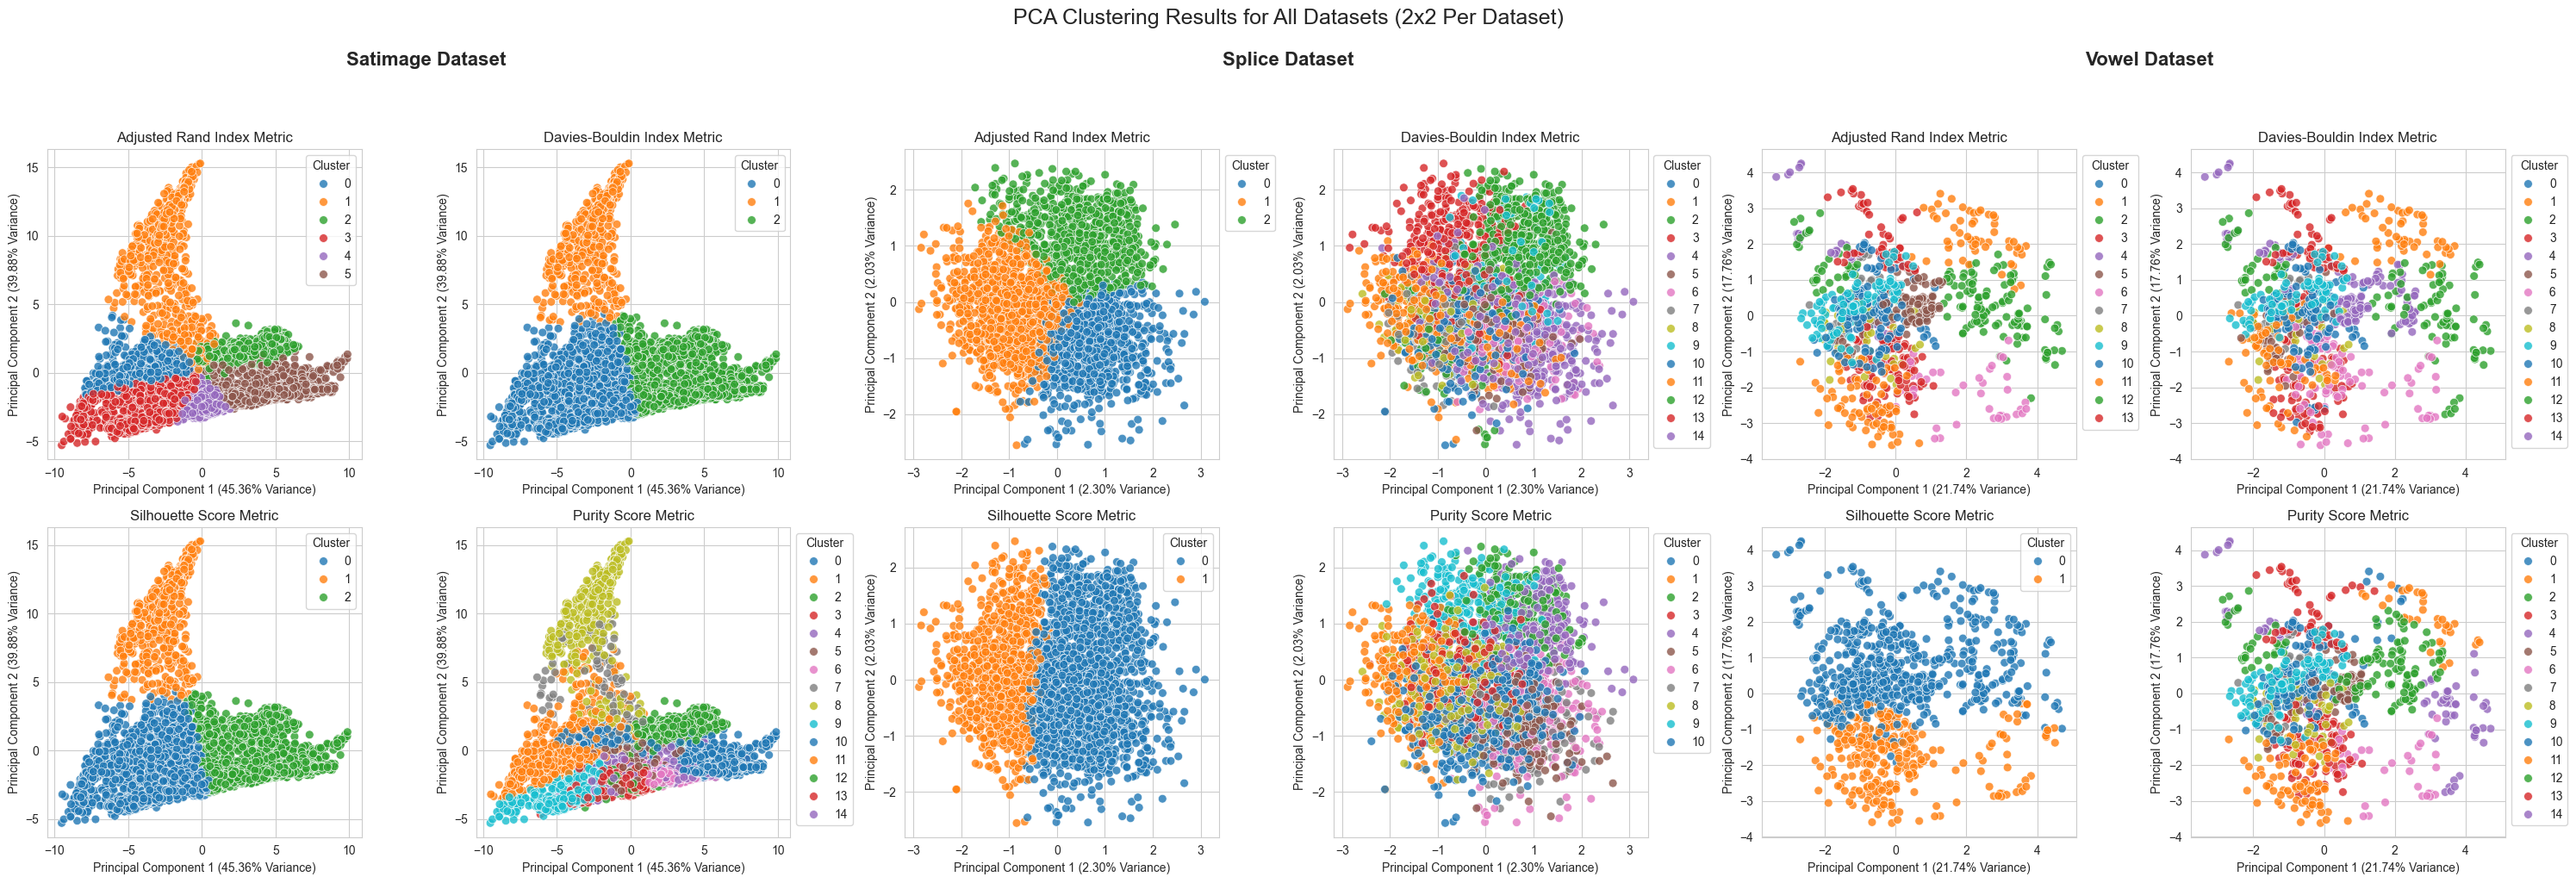

In [5]:
# Dimensionality Reduction and Single Row of 2x2 PCA Plots per Dataset with Titles, Variance Info, and Ordered Legends

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

# Set seaborn style for better aesthetics
sns.set_style('whitegrid')

# Total number of subplots: 2 (rows) x len(datasets)*2 (columns) for 2x2 per dataset in a single row
fig, axes = plt.subplots(2, len(datasets) * 2, figsize=(len(datasets) * 10, 10), sharex=False, sharey=False)

# Set the overall title higher to avoid overlap
fig.suptitle('PCA Clustering Results for All Datasets (2x2 Per Dataset)', fontsize=18, y=1.02)

# Iterate over datasets and metrics
for dataset_idx, dataset in enumerate(datasets):
    # Subplots indices for the dataset
    dataset_axes = axes[:, dataset_idx * 2:(dataset_idx + 1) * 2].flat
    
    # Add a title centered above the 2x2 grid for the current dataset
    x_center = (dataset_idx * 2 + 1) / (len(datasets) * 2)
    fig.text(x_center, 0.96, f'{dataset.capitalize()} Dataset', ha='center', va='center', fontsize=16, weight='bold')
    
    for ax, (metric, _) in zip(dataset_axes, metrics.items()):
        # Retrieve data and labels for the specific metric
        data = dataset_labels[dataset][metric]['data']
        labels = dataset_labels[dataset][metric]['labels']
        
        # Apply PCA
        pca = PCA(n_components=2)
        data_reduced = pca.fit_transform(data)
        variance_ratio = pca.explained_variance_ratio_ * 100  # Variance percentages
        
        # Create a DataFrame for plotting
        plot_df = pd.DataFrame(data_reduced, columns=['Principal Component 1', 'Principal Component 2'])
        plot_df['Cluster'] = labels
        # .astype(int)  # Convert to integers for proper numerical sorting
        
        # Ensure the legend is ordered numerically
        plot_df['Cluster'] = pd.Categorical(plot_df['Cluster'], categories=sorted(plot_df['Cluster'].unique()), ordered=True)
        
        # Plot
        sns.scatterplot(data=plot_df, x='Principal Component 1', y='Principal Component 2',
                        hue='Cluster', palette='tab10', ax=ax, s=50, alpha=0.8, legend='full')
        ax.set_title(f'{metric} Metric')
        ax.set_xlabel(f'Principal Component 1 ({variance_ratio[0]:.2f}% Variance)')
        ax.set_ylabel(f'Principal Component 2 ({variance_ratio[1]:.2f}% Variance)')
        ax.legend(title='Cluster', loc='best', bbox_to_anchor=(1, 1))
    
# Adjust the layout to leave room for titles
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust top margin to leave space for the suptitle
plt.show()


#### 3.3.3 Confusion matrices

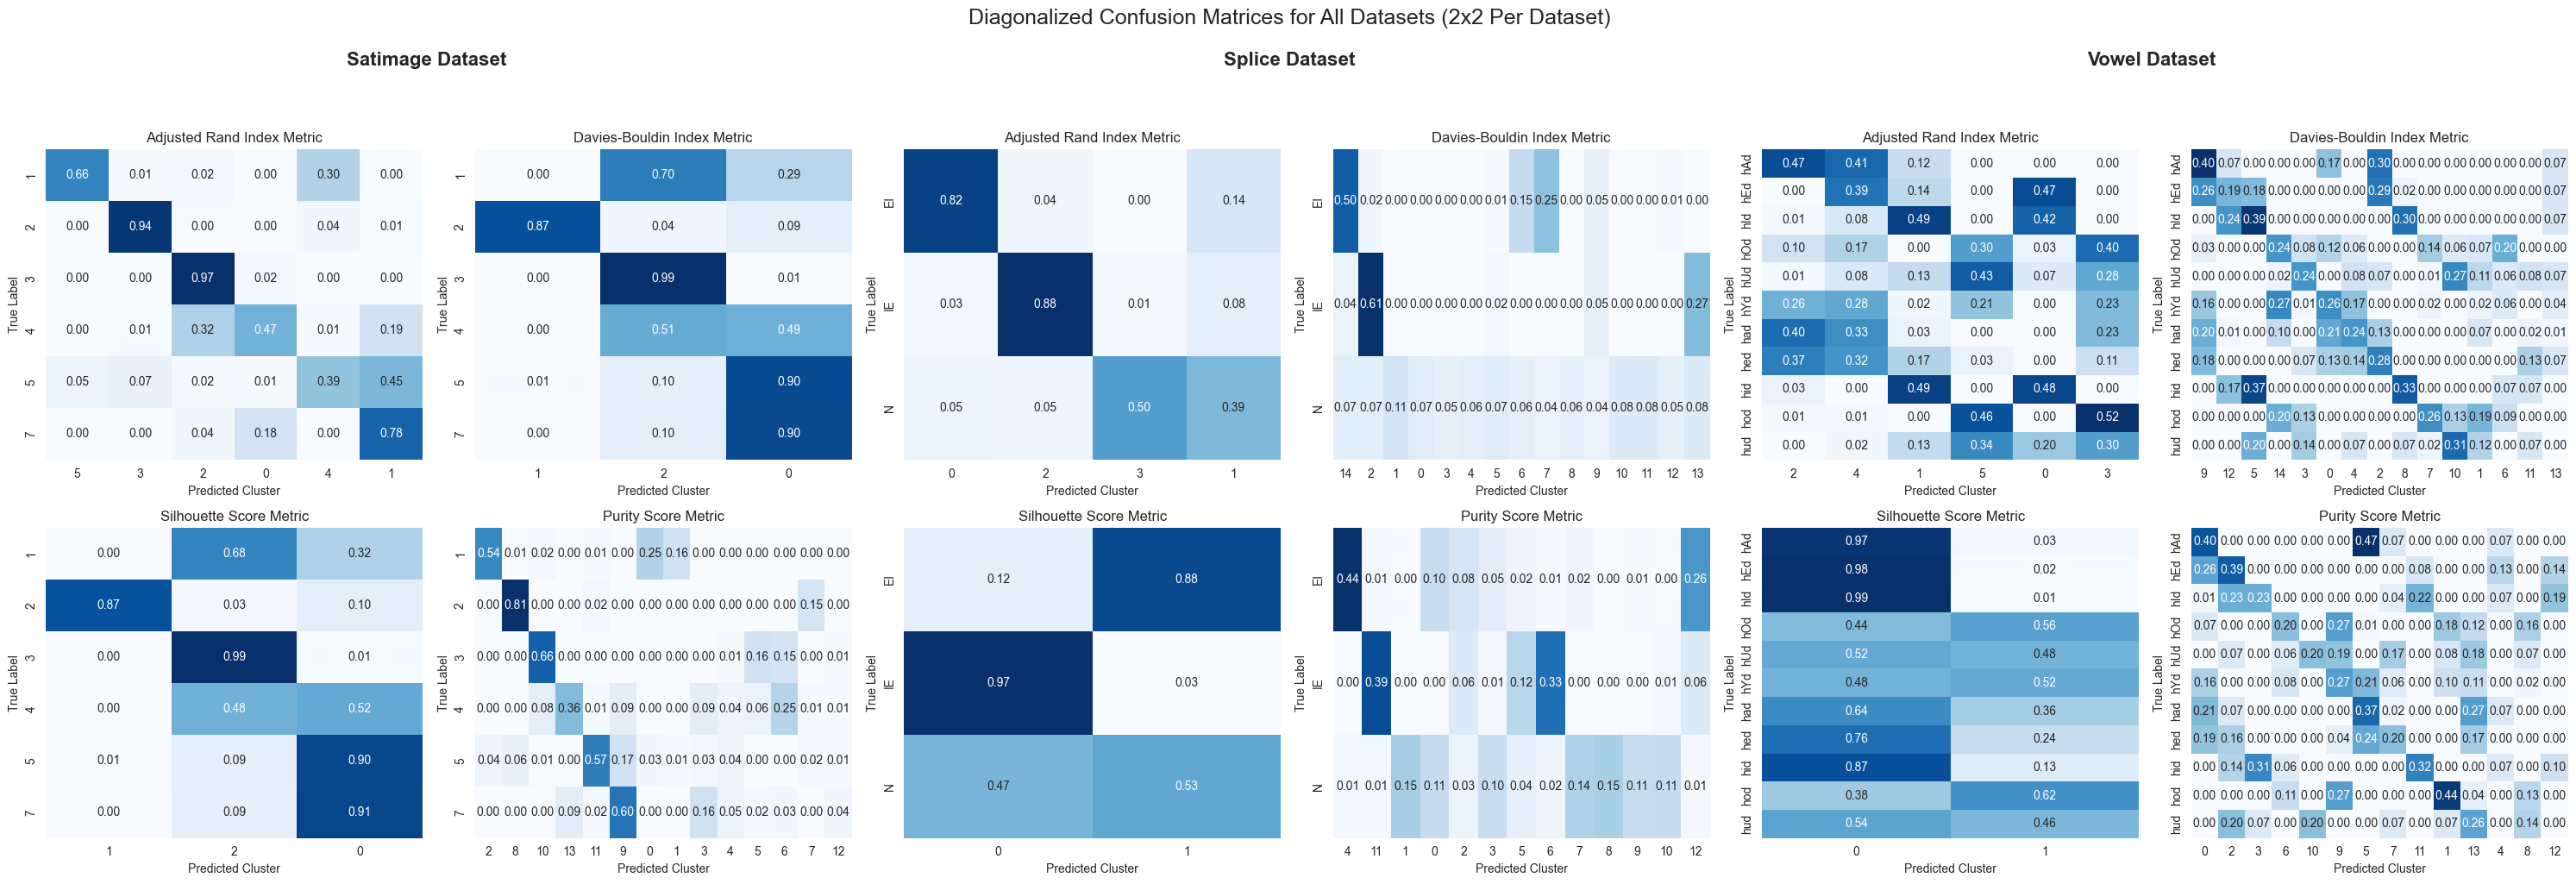

In [18]:
# Plotting Diagonalized Confusion Matrices for Each Metric in a 2x2 Grid per Dataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import numpy as np

# Set seaborn style for better aesthetics
sns.set_style('whitegrid')

# Total number of subplots: 2 (rows) x len(datasets)*2 (columns) for 2x2 per dataset in a single row
fig, axes = plt.subplots(2, len(datasets) * 2, figsize=(len(datasets) * 10, 10), sharex=False, sharey=False)

# Set the overall title higher to avoid overlap
fig.suptitle('Diagonalized Confusion Matrices for All Datasets (2x2 Per Dataset)', fontsize=18, y=1.02)

# Iterate over datasets and metrics
for dataset_idx, dataset in enumerate(datasets):
    # Subplots indices for the dataset
    dataset_axes = axes[:, dataset_idx * 2:(dataset_idx + 1) * 2].flat
    
    # Add a title centered above the 2x2 grid for the current dataset
    x_center = (dataset_idx * 2 + 1) / (len(datasets) * 2)
    fig.text(x_center, 0.96, f'{dataset.capitalize()} Dataset', ha='center', va='center', fontsize=16, weight='bold')
    
    for ax, (metric, _) in zip(dataset_axes, metrics.items()):
        # Retrieve true labels and predicted labels
        data_loader = DataLoader()
        _, y_true = data_loader.load_arff_data(dataset)
        y_pred = dataset_labels[dataset][metric]['labels']
        
        # Map true labels and predicted labels to consecutive integers
        y_true_unique = np.unique(y_true)
        y_pred_unique = np.unique(y_pred)
        
        y_true_mapping = {label: idx for idx, label in enumerate(y_true_unique)}
        y_pred_mapping = {label: idx for idx, label in enumerate(y_pred_unique)}
        
        y_true_mapped = np.array([y_true_mapping[label] for label in y_true])
        y_pred_mapped = np.array([y_pred_mapping[label] for label in y_pred])
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true_mapped, y_pred_mapped)
        
        # Apply the Hungarian algorithm to find the best assignment
        cost_matrix = cm.max() - cm  # Convert to cost matrix for maximization
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        # Reorder the confusion matrix
        cm_reordered = cm[:, col_ind]
        
        # Remove rows and columns that sum to 0
        non_zero_rows = np.any(cm_reordered > 0, axis=1)
        non_zero_cols = np.any(cm_reordered > 0, axis=0)
        cm_reordered = cm_reordered[non_zero_rows, :][:, non_zero_cols]
        
        # Normalize confusion matrix to [0,1]
        cm_row_sums = cm_reordered.sum(axis=1, keepdims=True)
        cm_row_sums[cm_row_sums == 0] = 1  # Avoid division by zero
        cm_normalized = cm_reordered.astype('float') / cm_row_sums
        
        # Generate labels for heatmap axes
        true_labels_names = [str(y_true_unique[i]) for i in range(len(y_true_unique)) if non_zero_rows[i]]
        pred_labels_names = [str(y_pred_unique[col_ind[j]]) for j in range(len(col_ind)) if non_zero_cols[j]]
        
        # Plot heatmap
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                    xticklabels=pred_labels_names, yticklabels=true_labels_names, cbar=False)
        ax.set_title(f'{metric} Metric')
        ax.set_xlabel('Predicted Cluster')
        ax.set_ylabel('True Label')

# Adjust the layout to leave room for titles
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust top margin to leave space for the suptitle
plt.show()
